# Разложение данных временных рядов с помощью анализа сингулярного спектра

Рассмотрим технику **анализа сингулярного спектра (SSA)**, метода декомпозиции временных рядов.

Проще говоря, SSA разбивает временной ряд на набор суммируемых компонентов, которые сгруппированы вместе и интерпретируются как *тренд*, *периодичность* и *шум*. SSA подчеркивает **разделимость** базовых компонентов и может легко разделить периодичности, которые возникают в разных временных масштабах, даже в данных очень зашумленных временных рядов. Исходный временной ряд восстанавливается путем суммирования всех его компонентов.

Таким образом, SSA можно использовать для анализа и восстановления временных рядов с различными компонентами или без них по желанию. Например, вы можете применить SSA к:
* построить сглаженную версию временного ряда, используя небольшое подмножество его компонентов;
* исследовать периодические компоненты временного ряда, чтобы понять лежащие в основе процессы, которые сформировали временной ряд;
* восстановить исходный временной ряд без его периодических составляющих;
* удалить все трендовые и периодические компоненты из ряда, оставив только «шум», который может иметь смысл сам по себе ...

 В отличие от широко используемого метода авторегрессионного интегрированного скользящего среднего (ARIMA), SSA не делает никаких предположений о природе временных рядов и имеет только один регулируемый (и легко интерпретируемый) параметр. Кроме того, для реализации базового алгоритма требуется немного больше, чем несколько строк из пакета numpy, так что вы можете легко создать свою собственную реализацию SSA, если хотите.

In [83]:
# Load the usual suspects:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd

# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

Первым шагом SSA является отображение временного ряда $ F $ в последовательность многомерных лаговых векторов. Пусть целое число $L$ будет **длиной окна**,$2 \le L \le N/2$. Мы формируем «окно», заданное подсериями $\{f_i, \ f_{i+1}, \ldots , \ f_{i+L-1}\}$, для $i=0,\ldots,N-L$. Мы перемещаем это окно по временному ряду, образуя вектор-столбец, $ X_i $, для каждой подсерии. То есть у нас есть

\begin{align*}
X_0 & = (f_0, \ f_1, \ f_2,  \ldots, \ f_{L-1} )^{\text{T}} \\
X_1 & = (f_1, \ f_2, \ f_3,  \ldots, \ f_L )^{\text{T}} \\
X_2 & = (f_2, \ f_3, \ f_4,  \ldots, \ f_{L+1} )^{\text{T}} \\
X_3 & = (f_3, \ f_4, \ f_5,  \ldots, \ f_{L+2} )^{\text{T}} \\
& \quad \quad \quad  \vdots \\
X_{N-L} & = (f_{N-L}, \ f_{N-L+1}, \ f_{N-L+2}, \ \ldots, \ f_{N-1} )^{\text{T}}.
\end{align*}

Эти векторы-столбцы образуют матрицу траекторий $L$ - *матрица траекторий*, $\mathbf{X}$ временного ряда (далее просто *матрицу траекторий*):

$$\mathbf{X} = \begin{bmatrix}
f_0 & f_1 & f_2 & f_3 &\ldots & f_{N-L} \\ 
f_1 & f_2 & f_3 & f_4 &\ldots & f_{N-L+1} \\
f_2 & f_3 & f_4 & f_5 &\ldots & f_{N-L+2} \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
f_{L-1} & f_{L} & f_{L+1} & f_{L+2} & \ldots & f_{N-1} \\ 
\end{bmatrix}$$

Из приведенной выше матрицы становится ясно, что элементы * антидиагоналей * (то есть диагоналей, идущих от нижнего левого угла к верхнему правому) равны. Этот тип матрицы известен как матрица *** Ганкеля ***.

<h3>1. Для анализа возьмем временной ряд - "daily-total-female-births-in-cal

In [84]:
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")
#dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
df = pd.Series(female_births["Count"])
#dowjones_closing
#df = pd.Series(dowjones_closing["Close"])
df

0      35
1      32
2      30
3      31
4      44
       ..
360    37
361    52
362    48
363    55
364    50
Name: Count, Length: 365, dtype: int64

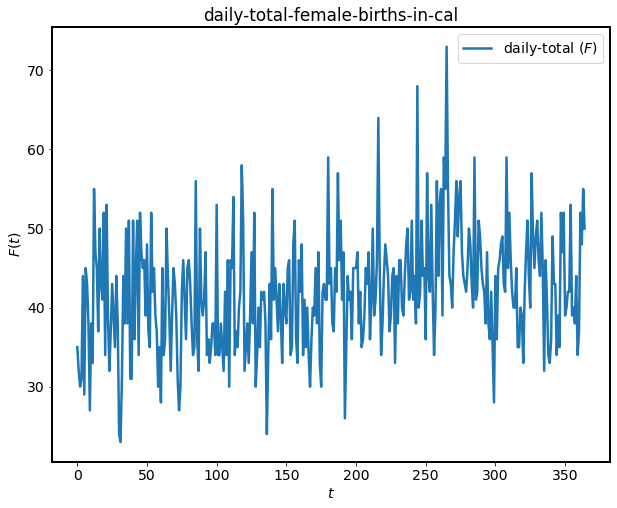

In [85]:
N = 365 # The number of time 'moments' in our toy series
t = np.arange(0,N)

F = df

# Plot everything
plt.plot(t, F, lw=2.5)
plt.legend(["daily-total ($F$)"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("daily-total-female-births-in-cal");

In [86]:
L = 100 # Длину оуна возьмем в размере 1/3 от количеств периодов
K = N - L + 1 # The number of columns in the trajectory matrix.
# Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
X = np.column_stack([F[i:i+L] for i in range(0,K)])
# Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive. 

Давайте возьмем момент, чтобы оценить матрицу траекторий во всей ее антидиагональной красоте:

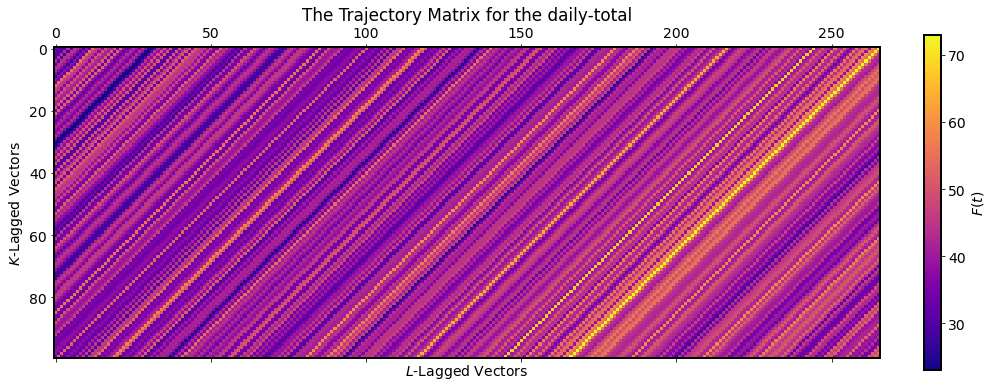

In [87]:
ax = plt.matshow(X)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for the daily-total");

## 2.2 разложения матрицы траектории<a name="Раздел 2.2"></a>и
Второй шаг-разложение матрицы траекторий с помощью [сингулярного разложения (SVD)](https://en.wikipedia.org/wiki/Singular-value_decomposition),

$$\mathbf{X} = \mathbf{U\Sigma V}^{\text{T}}$$
где:
* $\mathbf{U}$ - унитарная матрица $L \times L$, содержащая ортонормированное множество ***левых сингулярных векторов*** $\mathbf{X}$ в виде столбцов;
* $\mathbf{\Sigma}$ - прямоугольная диагональная матрица $L \times K$, содержащая $L$ ***сингулярные значения*** $\mathbf{X}$, упорядоченные от наибольшего к наименьшему; и
* $\mathbf{V}$ - это унитарная матрица $K \times K$, содержащая ортонормированное множество ***правых сингулярных векторов*** $\mathbf{X}$ в виде столбцов.

SVD матрицы траекторий можно переписать как
\begin{align*}
\mathbf{X} & = \sum_{i=0}^{d-1}\sigma_i U_i V_i^{\text{T}} \\
& \equiv \sum_{i=0}^{d-1}\mathbf{X}_i
\end{align*}
где $\sigma_i$ - это $i$ - е сингулярное значение, $U_i$ и $V_i$ - векторы, представляющие $i$ - е столбцы $\mathbf{U}$ и $\mathbf{V}$ соответственно, $d \le L$ - это *ранг* матрицы траекторий (о которой я расскажу вкратце), а $\mathbf{X}_i = \sigma_i U_i V_i^{\text{T}}$ - это $i$ - й элементарный элемент.матрица ***$\mathbf{X}$. Семейство $\{U_i, sigma_i\, V_i\}$ будем обозначать $i$е ***eigentriple*** из СВД.

Чтобы построить картину того, что все это означает, давайте рассмотрим матрицы $\mathbf{U}$, $\mathbf{V}$ и $\mathbf{\Sigma}$ по очереди.

### 2.2.1 Матрица $\mathbf{U}$<a name="Section2.2.1"></a>
$\mathbf{U}$ - это матрица $L \times L$, столбцы которой ортонормированы, то есть
$$
U_i \cdot U_j = \left\{
\begin{array}{lr}
1 \ & i = j \\
0 \ & i \ne j
\end{array}
\right.
$$
Это означает, что $\mathbf{UU}^{\text{T}} = \mathbf{U}^{\text{T}}\mathbf{U} = \mathbf{1}$, что делает $\mathbf{U}$ унитарной матрицей.

Выяснение роли, что $\mathbf{U}$ играет в аддоне для $\mathbf{X}$ и выше, пусть $Z_i = \sigma_i V_i$ быть вектор-столбец, так что
$$\mathbf{X} = \sum_{i=0}^{d-1} U_i Z_i^{\text{T}}$$
и каждый $L$-запаздывающий вектор столбца, $X_j$, тогда задается
$$X_j = \sum_{i=0}^{d-1}z_{j,i}U_i$$
где $z_{j,i}$ является компонентом есть $j$ - го вектора $Z_i$. Выражение для $X_j$ предполагает, что $\mathcal{U} = \{U_0,
\ldots, {d-1} \}$ является основой набора, охватывающих *столбец пространства* траектории матрица, и $z_{j,i}$ является $i$ом коэффициент изолированных вектор $X_j$, представленных в базисе $\mathcal{U}$. **Другими словами, столбцы матрицы $\mathbf{U}$ образуют ортонормированное базисное множество, описывающее временные подсерии $\left\{ f_i, \ldots, f_{i+L-1}\right\}_{i=0}^{N-L}$ в столбцах матрицы траекторий.**


### 2.2.2 Матрица $\mathbf{V}$<a name="Section2.2.2"></a>
Матрица $\mathbf{V}$—появляющаяся (по соглашению) как ее транспонирование в выражении для SVD $\mathbf{X}$—это матрица $K \times K$ с ортонормированными столбцами, которая, как и матрица $\mathbf{U}$, делает ее унитарной.

Чтобы интерпретировать столбцы $\mathbf{V}$ в SVD матрицы траектории, сначала отметим, что для любых матриц соответствующей формы $\mathbf{A}$ и $\mathbf{B}$, $\left(\mathbf{AB}\right)^{\text{T}} = \mathbf{B}^{\text{T}}\mathbf{A}^{\text{T}}$. Принимая транспонирование $\mathbf{X}$, мы, следовательно, имеем
\begin{align*}
\mathbf{X}^{\text{T}} & = \mathbf{V \Sigma}^{\text{T}}\mathbf{U}^{\text{T}} \\
& = \sum_{i=0}^{d-1}V_i Y_i^{\text{T}}
\end{align*}
где мы установили $Y_i = \sigma_i U_i$. Тогда
$$X^{(\text{T})}_j = \sum_{i=0}^{d-1}y_{j,i}V_i$$
где $X^{(\text{T})}_j$ - это $j$ - й столбец $\mathbf{X}^{\text{T}}$, а $y_{j,i}$ - это $j$ - й компонент вектора $Y_i$. Это выражение предполагает, что $\mathcal{V} = \{V_0, \ldots, V_{d-1}\}$ является базисным множеством,охватывающим пространство столбцов $\mathbf{X}^{\text{T}}$, а $y_{j, i}$ - это коэффициент $i$запаздывающего вектора $X^{(\text{T})}_j$, представленный в базисе $\mathcal{V}$. Эквивалентно, $\mathcal{V}$ - это базисный набор, охватывающий пространство строк $\mathbf{X}$. **То есть столбцы матрицы $\mathbf{V}$ образуют ортонормированный базисный набор, описывающий временные подсерии $\{ f_i, \ldots, f_{i+N-L}\}_{i=0}^{L-1}$ в строках матрицы траекторий.**

### 2.2.3 Матрица $\mathbf{\Sigma}$<a name="Section2.2.3"></a>
Матрица $\mathbf{\Sigma}$ - это прямоугольная диагональная матрица $L \times K$, содержащая **сингулярные значения** $\mathbf{X}$. Сингулярные значения упорядочены от наибольшего к наименьшему, то есть $\sigma_0 \ge \sigma_1 \ge \ldots \ge \sigma_{L-1} \ge 0$. **Мы можем интерпретировать $\sigma_i$ как масштабирующий фактор, определяющий относительную важность собственного примера $(U_i, \sigma_i, V_i)$ в разложении $\mathbf{X} = \sum_{i=0}^{d-1}\sigma_i U_i V_i^{\text{T}}$.**

В *Фробениус норма* из $\mathbf{X}$, $\lvert\lvert \mathbf{X} \\rvert rvert_{\text{F}}$, определяется по
$$\lvert\lvert \mathbf{X} \rvert\rvert_{\text{F}} = \sqrt{\sum_{j=0}^{L-1}\sum_{k=0}^{K-1} \lvert x_{j,k}\rvert^2}$$
где $x_{j,k}$ обозначает элемент в $j$ - й строке и $k$ - м столбце $\mathbf{X}$.

Обратим внимание на элементарные матрицы $\mathbf{X}_i = \sigma_i U_i V_i^{\text{T}}$. Теперь, для наружных продуктов, таких как $U_i V_i^{\text{T}}$, мы имеем $\lvert \lvert U_i V_i^{\text{T}} \rvert \rvert_{\text{F}} = \lvert \lvert U_i \rvert \rvert_{\text{F}} \lvert \lvert V_i \rvert \rvert_{\text{F}}$, который просто равен 1 из-за $U_i$ и $V_i$ самочувствие нормализуется. Из этого результата становится ясно, что $\lvert\lvert \mathbf{X}_i \rvert\rvert_{\text{F}} = \sigma_i$. Оказывается также, что
$$\lvert\lvert \mathbf{X} \rvert\rvert_{\text{F}}^2 = \sum_{i=0}^{d-1} \sigma_i^2$$
т. е. **квадратная норма Фробениуса матрицы траекторий равна сумме квадратов сингулярных значений. Это говорит о том, что мы можем принять соотношение $\sigma_i^2 / \lvert\lvert \mathbf{X} \rvert\rvert_{\text{F}}^2$ как меру вклада, который элементарная матрица $\mathbf{X}_i$ вносит в разложение матрицы траекторий.**

Далее, если мы правильно умножим исходный SVD $\mathbf{X}$ на $\mathbf{X}^{\text{T}}$:
\begin{align*}
\mathbf{XX}^{\text{T}} & = \mathbf{U\Sigma V}^{\text{T}}\mathbf{X}^{\text{T}} \\
& = \mathbf{U\Sigma V}^{\text{T}} \mathbf{V \Sigma}^{\text{T}}\mathbf{U}^{\text{T}} \\
& = \mathbf{U\Sigma} \mathbf{\Sigma}^{\text{T}}\mathbf{U}^{\text{T}}
\end{align*}
Пусть квадратная диагональная матрица $\mathbf{\Sigma}^2 = \mathbf{\Sigma \Sigma}^{\text{T}}$ и умножение справа на $\mathbf{U}$ дает
$$(\mathbf{XX}^{\text{T}})\mathbf{U} = \mathbf{U}\mathbf{\Sigma}^2$$
который—учитывая, что $\mathbf{\Sigma}^2$ является диагональной матрицей с элементами $\sigma_i^2$—демонстрирует, что столбцы $\mathbf{U}$ являются собственными векторами матрицы $\mathbf{XX}^{\text{T}}$ с собственными значениями $\{\sigma_0^2, \ldots, \sigma_{L-1}^2\}$. Следуя аналогичному аргументу, умножение $\mathbf{X}$ слева на $\mathbf{X}^{\text{T}}$ показывает, что столбцы $\mathbf{V}$ являются собственными векторами матрицы $\mathbf{X}^{\text{T}}\mathbf{X}$, также с собственными значениями $\{\sigma_0^2, \ldots , \sigma_{L-1}^2\}$.

### 2.2.4 ранг матрицы траектории<a name="Раздел 2.2.4"></a>и
Теперь мы можем говорить о *ранге*, $d$, матрицы траекторий. Столбцы матрицы траекторий представляют собой последовательность $L$-запаздывающих векторов, которые охватывают *пространство траекторий* временного ряда. Это пространство будет не более $L$-мерным; однако если столбцы в $\mathbf{X}$ линейно зависимы, то пространство траекторий будет иметь $d < L$ - мерности. Это проявляется в виде одного или нескольких нулевых сингулярных значений в $\mathbf{\Sigma}$. **Ранг $\mathbf{X}$ - это максимальное значение $i$ такое, что $\sigma_i > 0$. Другими словами, $d = \text{rank}\{\mathbf{X}\}$ можно рассматривать как инструментальную размерность пространства траекторий временных рядов.**

(Примечание: для зашумленных данных реального временного ряда траекторное пространство, скорее всего, будет иметь размеры $d = L$.)

Важно отметить, что каждая элементарная матрица $\mathbf{X}_i$ имеет ранг 1, и что матрица
$$\mathbf{X}^{(r)} = \sum_{i=0}^{r} \mathbf{X}_i$$
для $r < d$ является лучшим ранговым приближением$r$ к матрице траекторий $\mathbf{X}$, таким, что $\lvert\lvert \mathbf{X} - \mathbf{X}^{(r)}\rvert\rvert_F$ минимизируется. **То есть мы можем суммировать первые элементарные матрицы $r$, чтобы получить оптимальное, низкоразмерное приближение $\mathbf{X}$**.

### 2.2.5 собираем все вместе,<a name="Раздел 2.2.5"></a>и
Давайте быстро резюмируем все до сих пор: мы сопоставили временной ряд $F = \{f_0, \ldots, f_{N-1}\}$ набору многомерных запаздывающих векторов $X_i = (f_i, f_{i+1}, \ldots, f_{i+L-1})^{\text{T}}, i = 0, \ldots, N-L$, которые вместе составляют столбцы матрицы траекторий $\mathbf{X}$. Затем мы разложили эту матрицу с помощью SVD; при этом мы нашли два ортонормированных базисных набора, $\mathcal{U}$ и $\mathcal{V}$, которые охватывают пространство столбцов и строк соответственно матрицы траекторий. SVD $\mathbf{X}$ можно записать как
\begin{align*}
\mathbf{X} & = \sum_{i=0}^{d-1}\sigma_i U_i V_i^{\text{T}} \\
& \equiv \sum_{i=0}^{d-1}\mathbf{X}_i
\end{align*}
где $\mathbf{X}_i$ - это $i$ - я элементарная матрица $\mathbf{X}$, определяемая собственным числом $\{U_i, \sigma_i, V_i\}$. Сингулярное значение $i$th, $\sigma_i$, определяет относительный вклад $\mathbf{X}_i$ в разложение $\mathbf{X}$ выше. Целое число $d \le L$ является внутренней размерностью траекторного пространства временного ряда, и мы можем выбрать более низкоразмерную аппроксимацию $\mathbf{X}$, суммируя только первые элементарные матрицы $r < d$.

Многое из того, что мы рассмотрели до сих пор, является общим для SVD любой матрицы, а не только матрицы траекторий временного ряда. Отныне мы сосредоточимся на восстановлении компонентов временного ряда по его элементарным матрицам. На практике эти шаги довольно просты.

Хватит болтать — разложим матрицу траекторий и сформируем ее элементарные матрицы:

In [110]:
d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.

# For those interested in how to code up an SVD calculation, Numerical Recipes in Fortran 77
# has you covered: http://www.aip.de/groups/soe/local/numres/bookfpdf/f2-6.pdf
# Thankfully, we'll leave the actual SVD calculation to NumPy.
U, Sigma, V = np.linalg.svd(X)
V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless, 
# but I'll treat the Python representation of V consistently with the mathematical notation in this notebook.

# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
# This requires calculating sigma_i * U_i * (V_i)^T for each i, or sigma_i * outer_product(U_i, V_i). 
# Note that Sigma is a 1D array of singular values, instead of the full L x K diagonal matrix.
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

# Quick sanity check: the sum of all elementary matrices in X_elm should be equal to X, to within a 
# *very small* tolerance:
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

Let's take a peak at the first 12 elementary matrices.

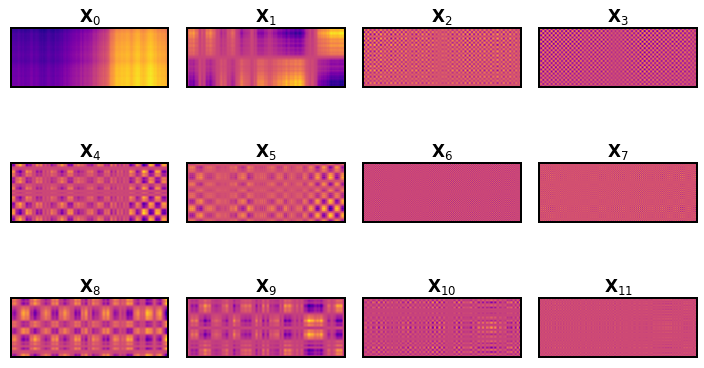

In [89]:
n = min(12, d) # In case d is less than 12 for the daily-total. Say, if we were to exclude the noise component...
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

Из визуального осмотра $\mathbf{X}_i$ выше очевидно, что элементарным матрицам не хватает антидиагональной структуры матрицы траекторий. Без проверки вектора $U_i$, связанного с каждым $\mathbf{X}_i$, или реконструкции временного ряда каждого компонента, появление $\mathbf{X}_i$ намекает на природу каждого компонента, будь то тренд, периодичность или шум. Например, $L$- и $K$-запаздывающие векторы в $\mathbf{X}_0$ и $\mathbf{X}_1$ изменяются относительно медленно по всей матрице, предполагая, что $\mathbf{X}_0$ и $\mathbf{X}_1$ могут быть связаны с общей тенденцией во временном ряду. Матрицы $\mathbf{X}_2$ to $\mathbf{X}_5$ показывают большие шахматные узоры, предполагающие периодичность. $\mathbf{X}_6$ может находиться где-то между периодичностью и трендом. Матрицы $\mathbf{X}_7$ и далее (и вплоть до $\mathbf{X}_{69}$), по-видимому, быстро чередуются между несколькими значениями; эти элементарные матрицы, вероятно, связаны с шумом в исходном временном ряду.

(Упражнение: повторите несколько ячеек выше, исключая шум из daily-total $F$. Что происходит с числом элементарных матриц? Какова внутренняя размерность пространства траекторий бесшумных рядов? Для смеха снова запустите ячейки только с шумовой составляющей в $F$ и обратите внимание на полученные элементарные матрицы. Зная, что "процесс", порождающий этот временной ряд, является случайным, считаете ли вы, что эти элементарные матрицы по отдельности содержат какую-либо полезную информацию?)

Построим график относительных вкладов $\dfrac{\sigma_i^2}{\sum_{k=0}^{d-1} \sigma_k^2}$ и кумулятивных вкладов $\dfrac{\sum_{j=0}^i \sigma_j^2}{\sum_{k=0}^{d-1} \sigma_k^2}$ первых 12 элементарных матриц в матрицу траекторий daily-total:

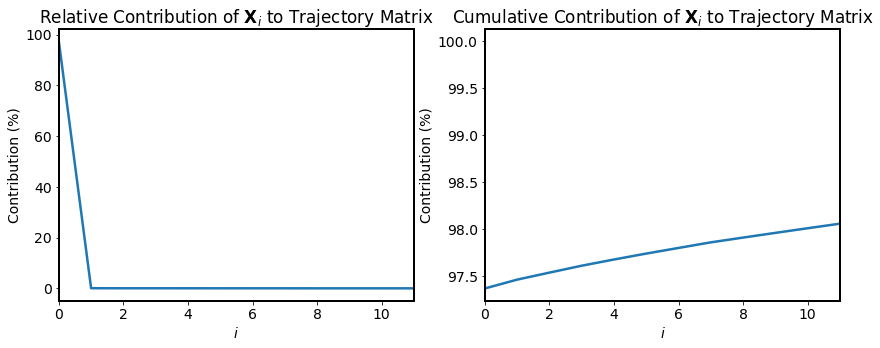

In [90]:
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,11)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");

На приведенных выше графиках изображены относительные и кумулятивные вклады первых 12 $\mathbf{X}_i$ в разложение $\mathbf{X} = \sum_{i=0}^{d-1}\mathbf{X}_i$. Элементарная матрица $\mathbf{X}_0$  вносит 97% в разложение $\mathbf{X}$.  Элементарные матрицы, которые вносят равный вклад в разложение (то есть $\sigma_i \approx \sigma_{i+1}$), вероятно, будут сгруппированы вместе при реконструкции временного ряда и появятся как "разрывы" в графике относительных вкладов. Например, "разрывы" на приведенном выше графике предполагают, что $\mathbf{X}_4$ и $\mathbf{X}_5$, а также $\mathbf{X}_8$ и $\mathbf{X}_9$ должны быть сгруппированы вместе.

Важно отметить, что элементарные матрицы представляют собой оптимальное (хотя, возможно, и не уникальное) разделение компонентов в пространстве траекторий: по определению, строки и столбцы одной элементарной матрицы ортогональны строкам и столбцам других элементарных матриц. Однако это разделение может не совпадать с тем, что мы считаем полезным, интерпретируемым "компонентом" временного ряда. На самом деле существуют ограничения на типы компонентов временных рядов, которые точно разделимы в рамках этого формализма.

## 2.3 реконструкции временных рядов<имя="Раздел 2.3"></A>и
До сих пор мы сопоставляли временной ряд $F$ с рядом векторов с запаздыванием $L$, образуя матрицу траекторий $F$. Затем мы разложили эту матрицу с помощью сингулярного разложения и построили набор элементарных матриц, которые составляют матрицу траекторий. Затем мы дали небольшое объяснение, чтобы классифицировать эти элементарные матрицы как *тренд*, *периодичность* и *шум*.

В идеальном мире все компоненты временного ряда $F = \sum_j F^{(j)}$ были бы разделимы, и мы бы сгруппировали полученные элементарные матрицы $\mathbf{X}_i$ соответствующим образом, так что
\begin{align*}
\mathbf{X} &  = \sum_{k \in \mathcal{S}}\mathbf{X}_k + \sum_{l \in \mathcal{T}}\mathbf{X}_l + \ldots \\
             &  = \sum_j \mathbf{X}^{(j)}
\end{align*}
где $\mathcal{S}$ и $\mathcal{T}$-непересекающиеся (т. е. неперекрывающиеся) множества индексов, а $\mathbf{X}^{(j)}$ - матрица траекторий компонента временного ряда $F^{(j)}$. В этом случае каждый $\mathbf{X}^{(j)}$ будет иметь структуру Ханкеля, подобную исходной матрице траекторий, и построение каждого $F^{(j)}$ будет простым. Однако в этом несовершенном реальном мире ни одна компонентная матрица траекторий не будет иметь равных значений на своих антидиагоналях. Поэтому мы ищем процесс преобразования элементарной матрицы в матрицу Ганкеля, а затем во временной ряд.

Чтобы извлечь временной ряд из элементарных матриц, мы будем использовать ***диагональное усреднение***, которое определяет значения восстановленного временного ряда $\tilde{F}^{(j)}$ как средние значения соответствующих антидиагоналей матриц $\mathbf{X}^{(j)}$. Формально это представлено путем внесения *Hankelisation* оператора, $\hat{\mathcal{H}}$, который действует на $L \times K$ матрицы $\mathbf{X}^{(j)}$, чтобы дать Ганкелева матрица $\mathbf{\tilde{X}}^{(j)}$; То есть,
$$\mathbf{\tilde{X}}^{(j)} = \hat{\mathcal{H}}\mathbf{X}^{(j)}$$ 
Элемент $\tilde{x}_{m,n}$ в $\mathbf{\tilde{X}}^{(j)}$, для $s = m+n$, задается
$$
\tilde{x}_{m,n} = \left\{
  \begin{array}{lr}
    \frac{1}{s+1}\sum_{l=0}^{s} x_{l, s-l} & \ 0 \le s \le L-1 \\
    \frac{1}{L-1}\sum_{l=0}^{L-1} x_{l, s-l} & \ L \le s \le K-1 \\
    \frac{1}{K+L-s-1}\sum_{l=s-K+1}^{L} x_{l, s-l} & \ K \le s \le K+L-2 \\
  \end{array}
\right.
$$

На первый взгляд все вышесказанное выглядит как непроницаемый суп из матричных индексов. Однако все, что он делает, - это вычисляет заданную $\tilde{x}_{m, n}$ путем усреднения остальных элементов антидиагонали,к которой принадлежит $\tilde{x}_{m, n}$. Количество антидиагональных элементов для суммирования зависит от расположения $m$ и $n$ в матрице, а следовательно, и от индекса супа. **На практике нам не нужна полная матрица Ханкеля $\mathbf{\tilde{X}}^{(j)}$, и мы можем сразу перейти к построению временного ряда $\tilde{F}^{(j)}$. Однако я включил определение $\hat{\mathcal{H}}\mathbf{X}^{(j)}$ выше, чтобы завершить математическое изложение SSA.**

Важно отметить, что $\hat{\mathcal{H}}$ является линейным оператором, т. е. $\hat{\mathcal{H}}(\mathbf{A} + \mathbf{B}) = \hat{\mathcal{H}}\mathbf{A} + \hat{\mathcal{H}}\mathbf{B}$. Тогда для матрицы траекторий $\mathbf{X}$,
\begin{align*}
\hat{\mathcal{H}}\mathbf{X} & = \hat{\mathcal{H}} \left( \sum_{i=0}^{d-1} \mathbf{X}_i \right) \\
& = \sum_{i=0}^{d-1} \hat{\mathcal{H}} \mathbf{X}_i \\
& \equiv \sum_{i=0}^{d-1} \tilde{\mathbf{X}_i}
\end{align*}
Поскольку $\mathbf{X}$ уже является матрицей Ханкеля, то по определению $\hat{\mathcal{H}}\mathbf{X} = \mathbf{X}$. Поэтому матрица траекторий может быть выражена в терминах ее элементарных матриц Ханкеля:
$$\mathbf{X} = \sum_{i=0}^{d-1} \tilde{\mathbf{X}_i}$$
Поскольку временной ряд однозначно определяется из матрицы Ханкеля, приведенное выше выражение также определяет временной ряд $F$ как сумму его компонентов $\tilde{F}_i$. Мы должны сгруппировать эти компоненты вместе и классифицировать их как тренд, периодичность или шум, а затем мы вольны решать, как мы их используем.

Для развлечения я реализовал процедуру Ханкелизации ниже. Однако не слишком привязывайтесь к нему, так как он будет выброшен и заменен чем-то гораздо более эффективным и питоническим.

In [91]:
def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning. 
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))
    
    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]    
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

Мы зашли так далеко, так что мы могли бы также Ханкелизировать несколько элементарных матриц daily-total, пока мы этим занимаемся:

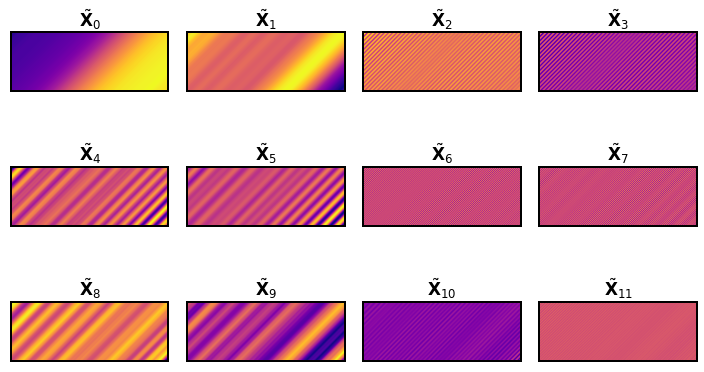

In [92]:
n = min(d, 12)
for j in range(0,n):
    plt.subplot(4,4,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout() 

Проверка элементарных матриц Ханкеля daily-total подтверждает наши подозрения относительно элементарных матриц: $\tilde{\mathbf{X}}_0$ и $\tilde{\mathbf{X}}_1$ медленно изменяются на протяжении всего временного ряда и могут быть сгруппированы вместе как компонент тренда. $\tilde{\mathbf{X}}_2$ и $\tilde{\mathbf{X}}_3$ являются периодическими с одинаковой частотой и могут быть сгруппированы как первый периодический компонент. $\tilde{\mathbf{X}}_4$ и $\tilde{\mathbf{X}}_5$ также являются периодическими, с другой частотой, чем $\tilde{\mathbf{X}}_2$ и $\tilde{\mathbf{X}}_3$, и будут сгруппированы как второй периодический компонент. $\tilde{\mathbf{X}}_6$, лишенные очевидной периодичности, будут сгруппированы с компонентами тренда. Мы объединим все компоненты из $\tilde{\mathbf{X}}_7$ и далее как шум. Подводя итог:
\begin{align*}
\tilde{\mathbf{X}}^{\text{(trend)}} & = \tilde{\mathbf{X}}_0
    & \implies &  \tilde{F}^{\text{(trend)}} = \tilde{F}_0 
\tilde{\mathbf{X}}^{\text{(periodic 1)}} & = \tilde{\mathbf{X}}_4 + \tilde{\mathbf{X}}_5 
    & \implies & \tilde{F}^{\text{(periodic 1)}} = \tilde{F}_4 + \tilde{F}_5  \\
\tilde{\mathbf{X}}^{\text{(periodic 2)}} & =\tilde{\mathbf{X}}_1 + \tilde{\mathbf{X}}_8 + \tilde{\mathbf{X}}_9 
    & \implies & \tilde{F}^{\text{(periodic 2)}} =\tilde{F}_1 + \tilde{F}_8 + \tilde{F}_9\\
\tilde{\mathbf{X}}^{\text{(noise)}} & = \tilde{\mathbf{X}}_2 + \ldots + \tilde{\mathbf{X}}_{99}
    & \implies & \tilde{F}^{\text{(noise)}} = \tilde{F}_2 + \ldots + \tilde{F}_{99}
\end{align*}
Хотя мы определили группировку компонентов временного ряда в терминах элементарных матриц Ханкеля, мы больше не будем вычислять полную матрицу Ханкеля $\tilde{\mathbf{X}}_i$, а вместо этого вычисляем $\tilde{F}_i$ непосредственно из $\mathbf{X}_i$. Далее мы сделаем это с помощью двух строк Python!

In [93]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

Давайте продолжим и построим первые 12 элементарных компонентов, $\tilde{F}_i$, для daily-total.

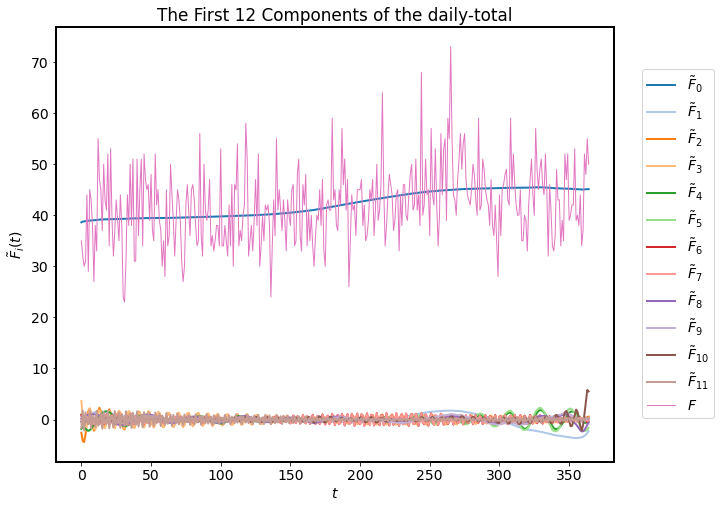

In [94]:
n = min(12,d) # In case of noiseless time series with d < 12.

# Fiddle with colour cycle - need more colours!
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, F, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 12 Components of the daily-total")
fig.legend(legend, loc=(1.05,0.1));

Как уже упоминалось ранее, элементарные компоненты, разделенные в пространстве траекторий временного ряда, могут не совпадать с одной интерпретируемой компонентой временного ряда. Например, $\tilde{F}_0$ и $\tilde{F}_1$ оба смутно похожи на тренд—действительно ли они являются отдельными компонентами? Аналогично, $\tilde{F}_2$ и $\tilde{F}_3$ почти идентичны, за исключением границ временного ряда.

Мы расскажем способ, чтобы определить $\tilde{F_i}$ должны быть сгруппированы вместе, но на мгновение, давайте следуем нашим инстинктам и применять ранее группировка для $\tilde{F}^{\text{(trend)}}$, $\tilde{F}^{\text{(periodic 1)}}$, $\tilde{F}^{\text{(periodic 2)}}$ и $\tilde{F}^{\text{(noise)}}$, и посмотреть, как SSA, разделенных компонентов сравнить с первоначальными компонентами, из которых состоит игрушка временных рядов:

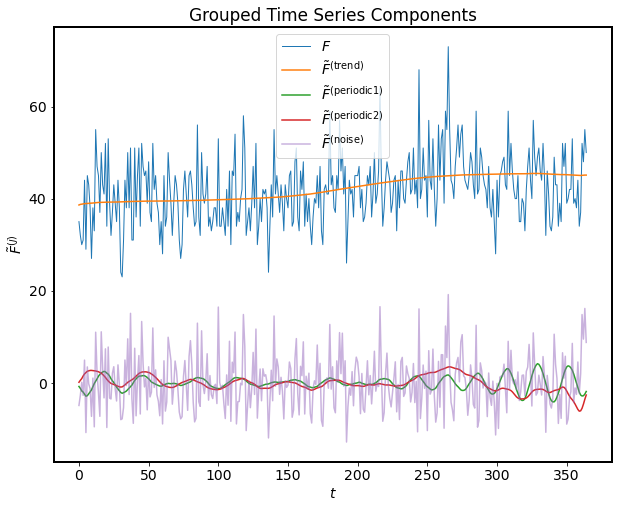

In [95]:
# Assemble the grouped components of the time series.
F_trend = X_to_TS(X_elem[[0]].sum(axis=0))
F_periodic1 = X_to_TS(X_elem[[4,5]].sum(axis=0))
F_periodic2 = X_to_TS(X_elem[[1,8,9]].sum(axis=0))
F_noise = X_to_TS(X_elem[10:].sum(axis=0))

# Plot the daily-total and its separated components on a single plot.
plt.plot(t,F, lw=1)
plt.plot(t, F_trend)
plt.plot(t, F_periodic1)
plt.plot(t, F_periodic2)
plt.plot(t, F_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend", "periodic 1", "periodic 2", "noise"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()




После того, как мы сгруппировали элементарные компоненты вместе, похоже, что SSA проделала большую работу по разделению исходных компонентов daily-total—особенно двух периодических компонентов с различными частотами и амплитудами. Однако разделение не является совершенным: все компоненты ухудшаются вблизи границ, особенно тренд и вторая периодическая составляющая. Это часто встречается в SSA и возникает из-за того, что в соответствии с формализмом SSA большинство типов рядов (т. Е. полиномиальных, синусоидальных, экспоненциальных и т. Д.) не являются точно разделимыми. Поэтому наша попытка восстановить *точный* параболический тренд и периодические компоненты из серии игрушек всегда была обречена на провал.

Однако это не означает, что компоненты временного ряда не могут быть "приблизительно разделимыми", как мы видели выше. (Существует также понятие *асимптотической отделимости*—когда длина временного ряда приближается к бесконечности,—однако по практическим соображениям мы не будем здесь рассматривать этот случай.)

# 3. Разделение и группировка компонентов временных рядов<a name="Section3"></a>

До сих пор мы группировали собственные элементы/компоненты daily-total вместе путем визуального осмотра; то есть мы определяли, какие компоненты принадлежат друг другу по их внешнему виду. Это хорошо для короткого и простого временного ряда, однако для более длинного и сложного временного ряда мы ищем метод, который количественно определяет, можно ли считать реконструированный компонент $\tilde{F}_i$ отдельным от другого компонента $\tilde{F}_j$, поэтому нам не нужно принимать решения о группировке, визуально проверяя каждый $\tilde{F}_i$.

Для двух реконструированных временных рядов, $\tilde{F}_i$ и $\tilde{F}_j$, длины $N$ и длины окна $L$, мы определяем *взвешенное внутреннее произведение*, $(\tilde{F}_i, \tilde{F}_j)_w$ как:
$$(\tilde{F}_i, \tilde{F}_j)_w = \sum_{k=0}^{N-1} w_k \tilde{f}_{i,k} \tilde{f}_{j,k}$$
где $\tilde{f}_{i,k}$ и $\tilde{F}_{J,k}$ находятся в $k$ - го значения $\tilde{F}_i$ и $\tilde{F}_j$, соответственно, и $w_k$ дается
$$
w_{k} = \left\{
  \begin{array}{lr}
    k+1 & \ 0 \le k \le L-1 \\
    L & \ L \le k \le K-1 \\
    N - k & \ K \le k \le N-1 \\
  \end{array}
\right.
$$
вспомним, что $K = N - L + 1$. Вес $w_k$ просто отражает количество раз,когда $\tilde{f}_{i,k}$ и $\tilde{f}_{j, k}$ появляются в ханкелизированных матрицах $\mathbf{\tilde{X}}_i$ и $\mathbf{\tilde{X}}_j$, из которых были получены временные ряды $\tilde{F}_i$ и $\tilde{F}_j$.

Проще говоря, если $(\tilde{F}_i, tilde{F}_j)_w = 0$, $\tilde{F}_i$ и $\tilde{F}_j$ находитесь *ж-ортогональных* и временного ряда компоненты являются съемными. Конечно, всего Вт-ортогональность не происходит в реальной жизни, так что вместо этого мы определяем $d \times d$ ***средневзвешенная корреляция*** матрица, $\mathbf{W}_{\text{corr}}$, который измеряет отклонение компоненты $\tilde{F}_i$ и $\tilde{F}_j$ и W-ортогональность. Элементы $\mathbf{W}_{\text{corr}}$ дает
$$W_{i,J} = \frac{(\tilde{F}_i, \tilde{F}_j)_w}{\lVert \tilde{F}_i \rVert_w \lVert \tilde{F}_j \rVert_w}$$
где $\lVert \tilde{F}_k \rVert_w = \sqrt{(\tilde{F}_k, \tilde{F}_k)_w}$ для $k = i,j$. Интерпретация $W_{i,j}$ проста: если $\tilde{F}_i$ и $\tilde{F}_j$ сколь угодно близки друг к другу (но не идентичны), то $(\tilde{F}_i, \tilde{F}_j)_w \rightarrow \lVert \tilde{F}_i \rVert_w \lVert \tilde{F}_j \rVert_w$ и, следовательно, $W_{i,j} \rightarrow 1$. Конечно, если $\tilde{F}_i$ и $\tilde{F}_j$ w-ортогональны, то $W_{i,j} = 0$. Умеренные значения $W_{i,j}$ между 0 и 1, скажем $W_{i,j} \ge 0.3$, указывают на компоненты, которые, возможно, необходимо сгруппировать вместе.

Без лишних слов построим w-корреляционную матрицу для daily-total:

In [96]:
# Get the weights w first, as they'll be reused a lot.
# Note: list(np.arange(L)+1) returns the sequence 1 to L (first line in definition of w), 
# [L]*(K-L-1) repeats L K-L-1 times (second line in w definition)
# list(np.arange(L)+1)[::-1] reverses the first list (equivalent to the third line)
# Add all the lists together and we have our array of weights.
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

# Get all the components of the toy series, store them as columns in F_elem array.
F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])

# Calculate the individual weighted norms, ||F_i||_w, first, then take inverse square-root so we don't have to later.
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

# Calculate the w-corr matrix. The diagonal elements are equal to 1, so we can start with an identity matrix
# and iterate over all pairs of i's and j's (i != j), noting that Wij = Wji.
Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

График w-корреляционной матрицы.

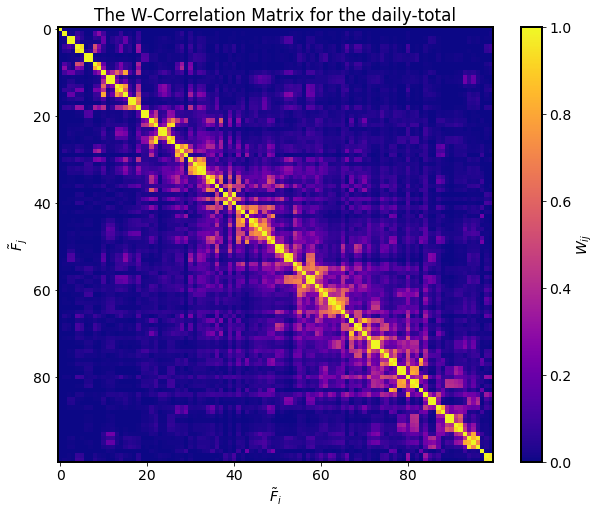

In [97]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.clim(0,1)
plt.title("The W-Correlation Matrix for the daily-total");

Структура $\mathbf{W}_{\text{corr}}$ показывает большую корреляцию между компонентами временного ряда, особенно в диапазоне $10 \le i,j \le 99$. Поскольку это были компоненты, которые мы классифицировали как принадлежащие к шуму во временном ряду, неудивительно, что между ними существуют не пренебрежимо малые корреляции; это естественный результат того, что шум не имеет лежащего в основе структурного компонента, который можно было бы далее отделить.

Важно отметить,что $\mathbf{W}_{\text{corr}}$ грубо разделен на два "блока": $0 \le i, j \le 9$ и $10 \le i,j \le 99$. Это соответствует двум основным группам: сглаженный временной ряд (т. е. тренд плюс две периодические компоненты) и остаточный шум. Масштабирование первых семи компонентов в $\mathbf{W}_{\text{corr}}$:

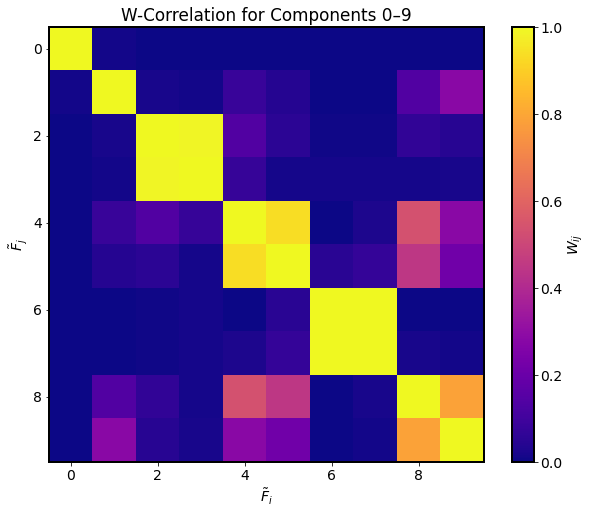

In [98]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.xlim(-0.5,9.5)
plt.ylim(9.5,-0.5)
plt.clim(0,1)
plt.title(r"W-Correlation for Components 0–9");

Из графика видно, что 0 элемент - тренд не имеет корреляции с другими элементами. Шумовые элементы 2,3 и 6,7 высококоррелированы. Потенциальные периодические 4,5 и 8,9 элементы также коррелированны что может говорить о наличии периодической составляющей в ряде. 

In [99]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

## 5. Длина окна<a name="Section5"></a>
Теперь мы создали механизм, позволяющий легко исследовать влияние параметра длины окна, $L$, на декомпозицию нашего daily-total.

### 5.1 $L = 2$ <a name="Section5.1"></a>
Длина окна 2 может показаться бесполезным выбором, но это хорошее место, чтобы начать и наблюдать, как временные ряды разлагаются на все больше и больше компонентов. Мы будем использовать удобный метод `SSA.components_to_df ()`, чтобы вернуть фрейм данных Pandas и построить все элементарные компоненты сразу.

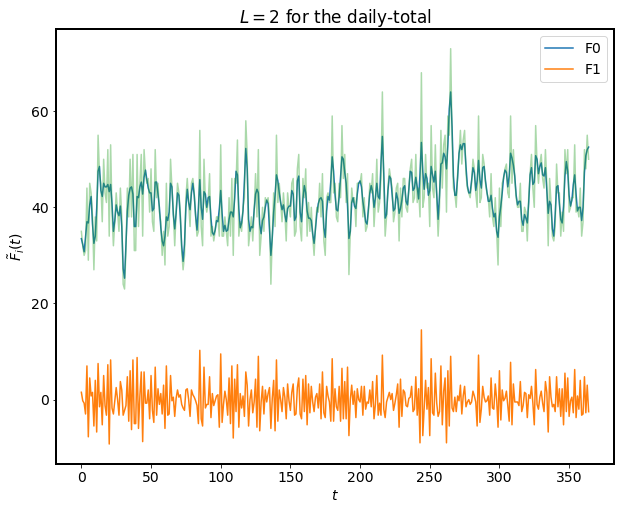

In [100]:
F_ssa_L2 = SSA(F, 2)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the daily-total");

Для $L=2$ мы можем ожидать возврата только двух элементарных компонентов. 

## 5.2 $L = 5$<a name="Section5.2"></a>
Давайте подойдем к окну длиной 5 и посмотрим, что происходит с элементарными компонентами:

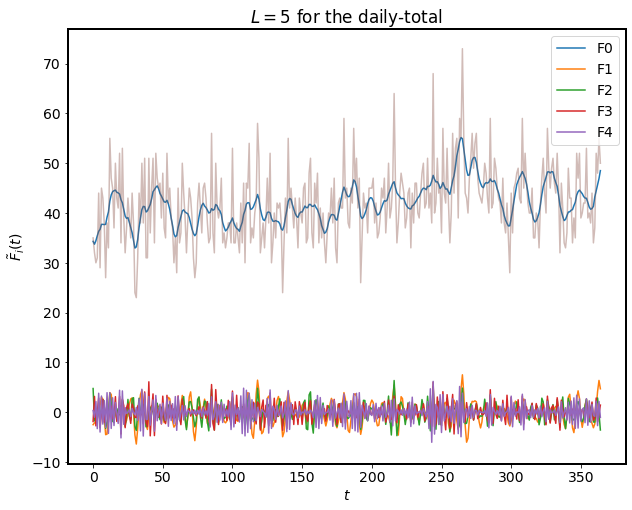

In [101]:
F_ssa_L5 = SSA(F, 5)
F_ssa_L5.components_to_df().plot()
F_ssa_L5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ for the daily-total");
plt.show()

Мы видим, что $\tilde{F}_0$ сейчас хорошо и по-настоящему обработанных версии оригинального сериала. $\tilde{F}_1$ является слабо растворяется периодической составляющей, в то время как $\tilde{F}_2$ для $\tilde{F}_4$ являются просто шумом.

## 5.3 $L = 20$<a name="Section5.3"></a>

Давайте увеличим длину окна в четыре раза, и вместо того, чтобы проверять элементарные компоненты, мы рассмотрим полученную w-корреляционную матрицу и сначала примем некоторые решения о группировке.

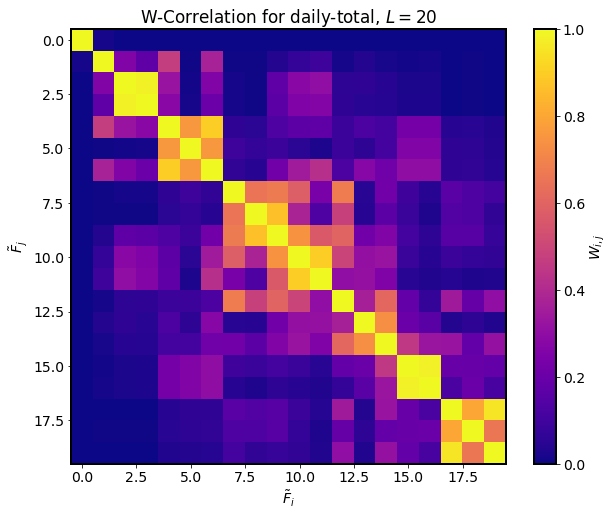

In [102]:
F_ssa_L20 = SSA(F, 20)
F_ssa_L20.plot_wcorr()
plt.title("W-Correlation for daily-total, $L=20$");

w-корреляционная матрица для $L=20$ разбита (грубо) на два блока: $\tilde{F}_0$ to $\tilde{F}_3$ и $\tilde{F}_4$ to $\tilde{F}_{19}$. Внутри этих блоков размер значений $W_{i,j}$ предполагает, что нам нужно сгруппировать $\tilde{F}_1$, $\tilde{F}_2$ и $\tilde{F}_3$, а также сгруппировать все $ \tilde{F}_4, \ldots,\tilde{F}_{19}$. Эта группировка, конечно, не идеальна, так как $\tilde{F}_3$ имеет не пренебрежимо малую w-корреляцию с компонентами во втором блоке. Мы построим выбранные нами группировки компонентов вместе с $\tilde{F}_3$ сами по себе и посмотрим, оправдан ли наш выбор группировки:

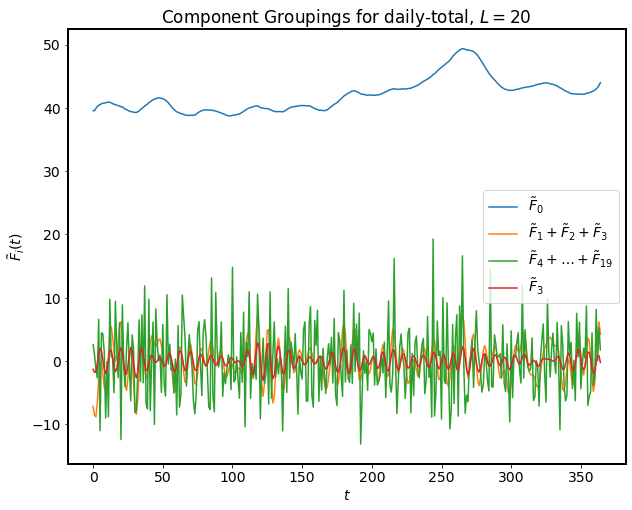

In [103]:
F_ssa_L20.reconstruct(0).plot()
F_ssa_L20.reconstruct([1,2,3]).plot()
F_ssa_L20.reconstruct(slice(4,20)).plot()
F_ssa_L20.reconstruct(3).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for daily-total, $L=20$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2+\tilde{F}_3$", 
            r"$\tilde{F}_4+ \ldots + \tilde{F}_{19}$",
            r"$\tilde{F}_3$"]);

При $L = 20$ мы начинаем видеть тренд и периодические компоненты начинают обретать форму. Одиночная составляющая $\tilde{F}_0$ выглядит еще как переодический тренд, а группа $\tilde{F}_1 + \tilde{F}_2 + \tilde{F}_3$ - очень периодичность, соответствующая сумме двух периодических компонент в исходном определении daily-total. Компонент $\tilde{F}_3$ вызывает беспокойство, так как выглядит так, как будто он вносит свой вклад как в шум*, так и в периодичность. Это говорит о том, что нам нужно увеличить длину окна и посмотреть, получим ли мы улучшенное разделение шума и периодичности.

## 5.4 $L = 40$<a name="Section5.4"></a>

Еще раз, мы удвоим длину окна и сначала проверим w-корреляционную матрицу.

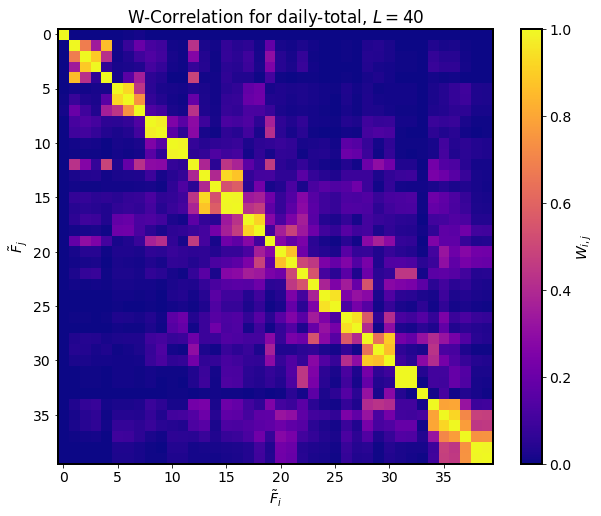

In [104]:
F_ssa_L40 = SSA(F, 40)
F_ssa_L40.plot_wcorr()
plt.title("W-Correlation for daily-total, $L=40$");

w-корреляционная матрица для $L=40$ сохраняет двухблочную структуру, с $\tilde{F}_0, \ldots, \tilde{F}_5$ в первом блоке и $\tilde{F}_6, \ldots, \tilde{F}_{39}$ во втором. Давайте сгруппируем компоненты следующим образом:
\begin{align*}
    \tilde{F}^{(0)} & = \tilde{F}_0 \\
    \tilde{F}^{(1)} & = \tilde{F}_1 + \tilde{F}_2 + \tilde{F}_3 \\
    \tilde{F}^{(2)} & = \tilde{F}_4 + \tilde{F}_5 \\
    \tilde{F}^{(3)} & = \tilde{F}_6 + \ldots + \tilde{F}_{39} \\
\end{align*}
Еще раз можно утверждать, что эта группировка не идеальна, учитывая не пренебрежимо малую w-корреляцию между, например, $\tilde{F}_0$ и $\tilde{F}_1$.

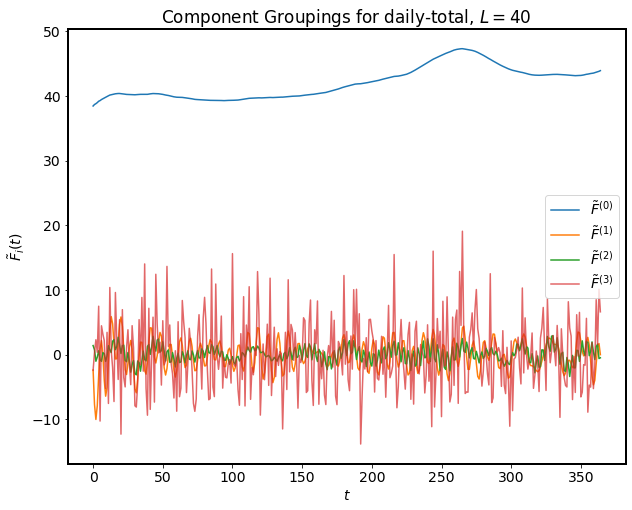

In [105]:
F_ssa_L40.reconstruct(0).plot()
F_ssa_L40.reconstruct([1,2,3]).plot()
F_ssa_L40.reconstruct([4,5]).plot()
F_ssa_L40.reconstruct(slice(6,40)).plot(alpha=0.7)
plt.title("Component Groupings for daily-total, $L=40$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(4)]);

Интересно, что компонент тренда $\tilde{F}^{(0)}$ начал улучшаться при $L=40$, с заметными "сглаживанием" во временном ряду. Периодичность в серии  нечетко разделена на две периодические компоненты с амплитудами и частотами. На данном этапе длина нашего окна составляет 1/9 от длины временного ряда.

## 5.5 $L = 90$<a name="Section5.5"></a>
Теперь мы приближаемся к нашему первому выбору $L=100$, поэтому стоит исследовать, как декомпозиция сходится к нашим первоначальным результатам. Сначала проверьте w-корреляционную матрицу:

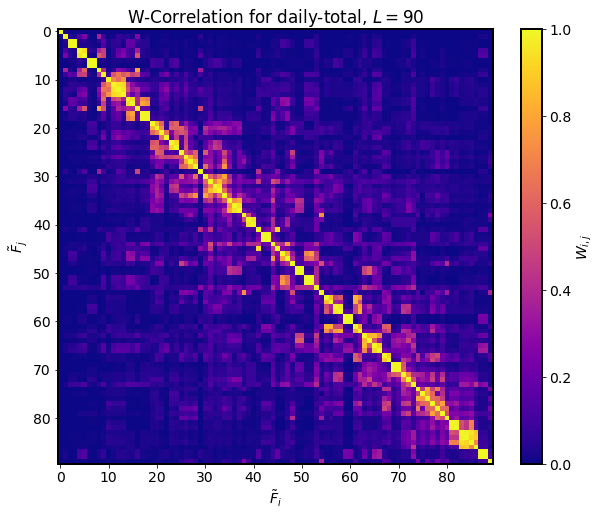

In [106]:
F_ssa_L90 = SSA(F, 90)
F_ssa_L90.plot_wcorr()
plt.title("W-Correlation for daily-total, $L=90$");

Как и в случае с исходным результатом $L=100$, матрица w-корреляции теперь состоит из двух отдельных блоков: $\tilde{F}_0$ to $\tilde{F}_9$ и $\tilde{F}_{10}$ to $\tilde{F}_{99}$. Из опыта теперь ясно, что $\tilde{F}^{\text{(signal)}} = \sum_{i=0}^9 \tilde{F}_i$ будет комбинированной трендовой и периодической компонентами ('signal'), а $\tilde{F}^{\text{(noise)}} = \sum_{i=10}^{99} \tilde{F}_i$ будет шумом.:

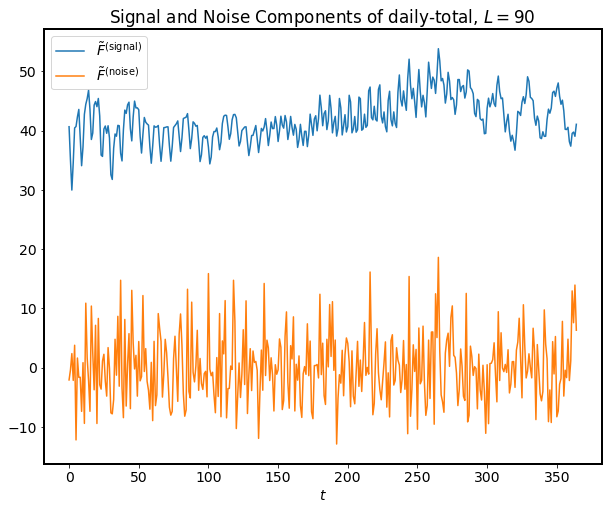

In [107]:
F_ssa_L90.reconstruct(slice(0,9)).plot()
F_ssa_L90.reconstruct(slice(10,99)).plot()
plt.legend([r"$\tilde{F}^{\mathrm{(signal)}}$", r"$\tilde{F}^{\mathrm{(noise)}}$"])
plt.title("Signal and Noise Components of daily-total, $L = 90$")
plt.xlabel(r"$t$");

Просмотр w-корреляционной матрицы для компонентов 0-9:

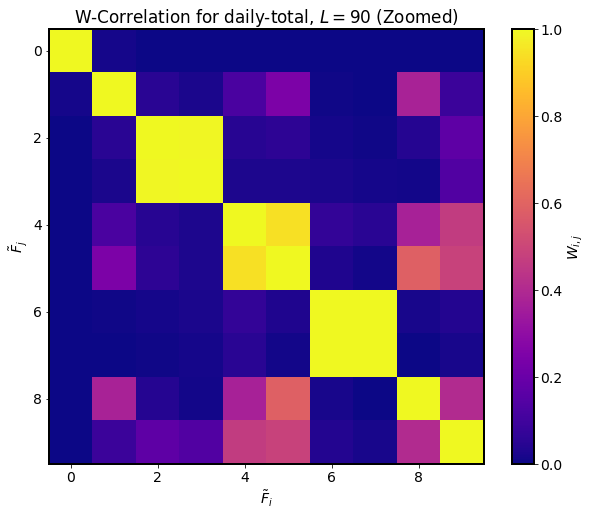

In [108]:
F_ssa_L90.plot_wcorr(max=9)
plt.title("W-Correlation for daily-total, $L=90$ (Zoomed)");

Чтобы понять, почему существует не пренебрежимо малая w-корреляция между большинством из первых девяти компонентов, будет разумно построить их все сразу:

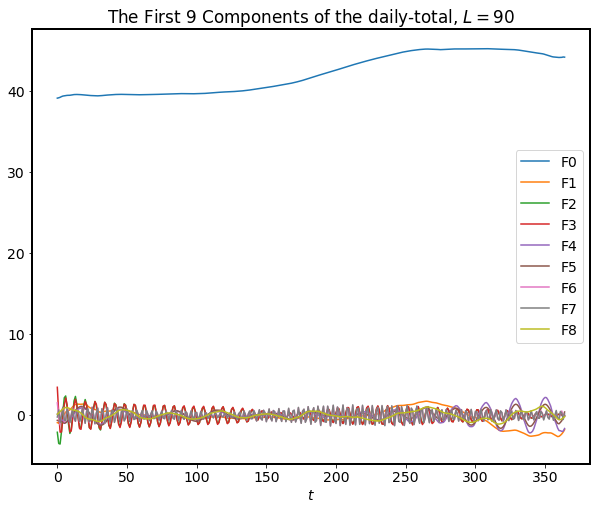

In [109]:
F_ssa_L90.components_to_df(n=9).plot()
plt.title(r"The First 9 Components of the daily-total, $L=90$")
plt.xlabel(r"$t$");

Из приведенного выше графика видно, что трендовая составляющая $\tilde{F}_1$ содержит колебания той же частоты, что и периодические компоненты $\tilde{F}_2$ и $\tilde{F}_3$, что приводит к существенным w-корреляциям. Как мы уже видели (см. [Раздел 2.3](#Section2.3)), увеличения длины окна до $L = 90$ достаточно, чтобы почти полностью устранить эти колебания. Конечно, можно увеличить длину окна еще больше—до $L = N/2 = 100$ в этом случае—однако за пределами $L=90$ компоненты временного ряда, генерируемые ведущими семью собственными матрицами, (относительно) нечувствительны к длине окна.

В SSA нет жестких и быстрых правил для установки идеальной длины окна, выходящей за пределы $2 \le L \le N/2$. Тем не менее, иногда требуется более длинная длина окна (до 30-45% длины временного ряда), чтобы адекватно отделить лежащие в основе периодичности от общего тренда. Некоторые методы проб и ошибок необходимы, но часто легко начать с "достаточно большой" длины окна и работать оттуда.

(Упражнение: почему длина окна $L$ ограничена диапазоном $2 \le L \le N/2$? Подсказка: рассмотрим выражение для SVD транспонированной матрицы траекторий $\mathbf{X}^{\text{T}} = \mathbf{V \Sigma}^{\text{T}}\mathbf{U}^{\text{T}}$ для матрицы траекторий, когда $N/2 < L < N$.)

# 7. Заключение<a name="Section7"></a>

Благодаря встраивания, декомпозиции и реконструкции метод анализа сингулярного спектра может извлекать тренд временного ряда, отделять лежащие в его основе периодичности и удалять шум.
Его можно использовать как исследовательский инструмент или в контексте более детального анализа.

# 8. Вывод <a name="Section7"></a>

<h3>Рассмотренный нами ряд является стационарным, что предполагает определенные сложности в выделении в ряде тренда, периодической и шумовой составляющей. В целом это подтвердило и разложение ряда на 12 матриц. Трендовая составляющая Х0 дала 97,5% вклада в точность оценки. При этом начиная с Х3 видно чередование периодических и шумовых матриц. Увеличение ширины окна позволило получить более сглаженную линию тренда. Также появились периодические составляющие, но в то тоже время они не имеют четкого синусоидального характера, есть разброс дисперсии и вероятно наличие невыделенного шума.